In [ ]:
!pip install PyMuPDF PyPDF2 spacy nltk langdetect beautifulsoup4 requests pandas tqdm gdown

In [25]:
import sys
import os
import re
import spacy
import json
import gdown

try:
    print("Modelo spaCy para português encontrado. Carregando...")
    nlp_pt = spacy.load("pt_core_news_lg")
except OSError:
    print("Modelo spaCy para português não encontrado. Fazendo download...")
    os.system("python -m spacy download pt_core_news_lg")
    nlp_pt = spacy.load("pt_core_news_lg")

stopwords_pt = nlp_pt.Defaults.stop_words


# 🔗 Substitua por seu ID ou link compartilhável do Google Drive
drive_file_id = '1GyhNwaP5c8qcclTgJVxFaqn9lYItJyQa'  # <-- apenas o ID
output_filename = 'corpus_bracis.json'

# Verifica se o arquivo já existe
if not os.path.exists(output_filename):
    url = f'https://drive.google.com/uc?id={drive_file_id}'
    print(f'⬇️ Baixando {output_filename}...')
    gdown.download(url, output_filename, quiet=False)
else:
    print(f'✅ O arquivo "{output_filename}" já existe.')


try:
    with open('corpus_bracis.json', 'r', encoding='utf-8') as f:
        corpus = json.load(f)
        
except Exception as e:
    print(f"Erro ao abrir o arquivo JSON: {e}")
    sys.exit

print("✅ Concluido.")

⬇️ Baixando corpus_bracis.json...


Downloading...
From: https://drive.google.com/uc?id=1GyhNwaP5c8qcclTgJVxFaqn9lYItJyQa
To: C:\Users\mucar\digger\topicosbd\corpus_bracis.json
100%|███████████████████████████████████████████████████████████████| 7.91M/7.91M [00:01<00:00, 6.06MB/s]


Modelo spaCy para português encontrado. Carregando...
✅ Concluido.


Percorre o corpus acumulando todos os tokens e sentenças e realiza uma contagem das classes gramaticais: substantivos, verbos e preposições (com e sem Stopwords)

In [5]:

def limpar_texto(texto):
    # Normaliza quebras de linha e espaços
    texto = re.sub(r'[\n\r\t]+', ' ', texto)
    texto = re.sub(r'\s+', ' ', texto)
    # Substituir caracteres Unicode problemáticos
    texto = texto.replace("−", "-").replace("—", "-").replace("–", "-")
    return texto.strip()

tokens_corpus = []
tokens_filtrado_corpus = []
sentencas_com_sw_corpus = []
sentencas_sem_sw_corpus = []
qtd_substantivos_com_sw_corpus = 0
qtd_verbos_com_sw_corpus = 0
qtd_preposicoes_com_sw_corpus = 0
qtd_substantivos_sem_sw_corpus = 0
qtd_verbos_sem_sw_corpus = 0
qtd_preposicoes_sem_sw_corpus = 0


for estrutura_artigo_corpus in corpus:
    print("Extraindo: " + estrutura_artigo_corpus["titulo"])
    texto_artigo = estrutura_artigo_corpus["artigo_completo_PT"]
    texto = limpar_texto(texto_artigo)
    
    nlp_texto = nlp_pt(texto_artigo)
    tokens = estrutura_artigo_corpus["artigo_tokenizado"]
    sentencas_com_sw = [s.text.strip() for s in nlp_texto.sents]
    tokens_filtrado = [t for t in tokens if t.lower() not in stopwords_pt]
    texto_para_sentencas_sem_sw = " ".join(tokens_filtrado)

    nlp_texto_sem_sw = nlp_pt(texto_para_sentencas_sem_sw)
    sentencas_sem_sw = [s.text.strip() for s in nlp_texto_sem_sw.sents]
    
    
    # Análise gramatical
    qtd_substantivos_com_sw = 0
    qtd_verbos_com_sw = 0
    qtd_preposicoes_com_sw = 0
    
    qtd_substantivos_sem_sw = 0
    qtd_verbos_sem_sw = 0
    qtd_preposicoes_sem_sw = 0
    
    if len(texto_artigo) > nlp_pt.max_length:
        nlp_pt.max_length = len(texto_artigo) + 1000
    
    for token in nlp_texto:
        if token.pos_ == "NOUN":
            qtd_substantivos_com_sw += 1
        elif token.pos_ == "VERB":
            qtd_verbos_com_sw += 1
        elif token.pos_ == "ADP":
            qtd_preposicoes_com_sw += 1

    for token in nlp_texto:
        if token.pos_ == "NOUN":
            qtd_substantivos_sem_sw += 1
        elif token.pos_ == "VERB":
            qtd_verbos_sem_sw += 1
        elif token.pos_ == "ADP":
            qtd_preposicoes_sem_sw += 1

    tokens_corpus.extend(tokens)
    tokens_filtrado_corpus.extend(tokens_filtrado)
    
    sentencas_com_sw_corpus.extend(sentencas_com_sw)
    sentencas_sem_sw_corpus.extend(sentencas_sem_sw)
    
    qtd_substantivos_com_sw_corpus += qtd_substantivos_com_sw
    qtd_verbos_com_sw_corpus += qtd_verbos_com_sw
    qtd_preposicoes_com_sw_corpus = qtd_preposicoes_com_sw
    
    qtd_substantivos_sem_sw_corpus += qtd_substantivos_sem_sw
    qtd_verbos_sem_sw_corpus += qtd_verbos_sem_sw
    qtd_preposicoes_sem_sw_corpus = qtd_preposicoes_sem_sw
print("✅ Concluido.")

Extraindo: A Large Dataset of Spontaneous Speech with the Accent Spoken in São Paulo for Automatic Speech Recognition Evaluation
Extraindo: A Transformer-Based Tabular Approach to Detect Toxic Comments
Extraindo: An Ensemble of LLMs Finetuned with LoRA for NER in Portuguese Legal Documents
Extraindo: Aroeira: A Curated Corpus for the Portuguese Language with a Large Number of Tokens
Extraindo: Assessing European and Brazilian Portuguese LLMs for NER in Specialised Domains
Extraindo: Automatic Text Simplification for the Legal Domain in Brazilian Portuguese
Extraindo: Developing Resource-Efficient Clinical LLMs for Brazilian Portuguese
Extraindo: Diversity in Data for Speech Processing in Brazilian Portuguese
Extraindo: ERASMO: Leveraging Large Language Models for Enhanced Clustering Segmentation
Extraindo: Evaluating Large Language Models for Tax Law Reasoning
Extraindo: Evaluating Sentiment Quantification Methods in Brazilian Portuguese Corpora
Extraindo: Evaluating Short Text Stream 

Calcula dados e monta Dataframe

In [6]:
import numpy as np
from collections import Counter
import pandas as pd

def word_tokenize_spacy(texto):
    doc = nlp_pt(texto)
    return [token.text for token in doc]

print("Calculando...")
num_sentencas_com_sw = len(sentencas_com_sw_corpus)
num_tokens_com_sw = len(tokens_corpus)

# Média de tokens por sentença COM stopwords
# palavras_por_sentenca = [len(word_tokenize_spacy(s)) for s in sentencas_com_sw_corpus]
# media_tokens_sentenca_com_sw = float(np.mean(palavras_por_sentenca)) if palavras_por_sentenca else 0.0

# Top e bottom tokens COM stopwords
freq_com_sw = Counter(tokens_corpus)
top_10_com_sw = [token for token, _ in freq_com_sw.most_common(10)]
bottom_10_com_sw = [token for token, _ in freq_com_sw.most_common()[-10:]] if len(freq_com_sw) >= 10 else []

# Calcula métricas SEM stopwords
num_sentencas_sem_sw = len(sentencas_sem_sw_corpus)
num_tokens_sem_sw = len(tokens_filtrado_corpus)

# Média de tokens por sentença SEM stopwords
# palavras_por_sentenca_sem_sw = [len(word_tokenize_spacy(s)) for s in sentencas_sem_sw_corpus]
# media_tokens_sentenca_sem_sw = float(np.mean(palavras_por_sentenca_sem_sw)) if palavras_por_sentenca_sem_sw else 0.0

# Top e bottom tokens SEM stopwords
freq_sem_sw = Counter(tokens_filtrado_corpus)
top_10_sem_sw = [token for token, _ in freq_sem_sw.most_common(10)]
bottom_10_sem_sw = [token for token, _ in freq_sem_sw.most_common()[-10:]] if len(freq_sem_sw) >= 10 else []
dados = pd.DataFrame({
    "Conjunto": ["WP Fast + stop", "WP Fast – stop"],
    "Sentenças": [num_sentencas_com_sw, num_sentencas_sem_sw],
    "Média de sentenças": [round(num_sentencas_com_sw/26, 2), round(num_sentencas_sem_sw/26,2)],
    "Tokens": [num_tokens_com_sw, num_tokens_sem_sw],
    "Média Tokens/Sent.": [
        round(num_tokens_com_sw / num_sentencas_com_sw, 2) if num_sentencas_com_sw > 0 else 0,
        round(num_tokens_sem_sw / num_sentencas_sem_sw, 2) if num_sentencas_sem_sw > 0 else 0
    ],
    "Top-10": [", ".join(top_10_com_sw), ", ".join(top_10_sem_sw)],
    "Down-10": [", ".join(bottom_10_com_sw), ", ".join(bottom_10_sem_sw)],
    "Substantivos": [qtd_substantivos_com_sw_corpus, qtd_substantivos_sem_sw_corpus],
    "Verbos": [qtd_verbos_com_sw_corpus, qtd_verbos_sem_sw_corpus],
    "Preposições": [qtd_preposicoes_com_sw_corpus, qtd_preposicoes_sem_sw_corpus]
})
print("✅ Concluido.")

Calculando...
✅ Concluido.


Exibe dados em tabelas


Tabela (Com stopwords):


,Sentenças,Média de sentenças,Tokens,Média Tokens/Sent.,Substantivos,Verbos,Preposições
0,7272,279.69,125403,17.24,34082,14060,914




Tabela (Sem stopwords):


,Sentenças,Média de sentenças,Tokens,Média Tokens/Sent.,Substantivos,Verbos,Preposições
0,10726,412.54,73363,6.84,34082,14060,914


,Top-10 (com stopwords),Top-10 (sem stopwords)
Posição,,
1,de,dados
2,e,modelos
3,a,modelo
4,o,conjunto
5,em,texto
6,para,desempenho
7,do,resultados
8,que,treinamento
9,um,português


,Down-10 (com stopwords),Down-10 (sem stopwords)
Posição,,
1,"0,250",competidores
2,"0,300","0,250"
3,"0,325","0,300"
4,Pre-treinamos,"0,325"
5,TweetSentBr,Pre-treinamos
6,top,TweetSentBr
7,favor,top
8,incrementais,incrementais
9,permaneceu,permaneceu



Gráfico Comparativo - Sentenças × Tokens:


<Figure size 1200x600 with 0 Axes>

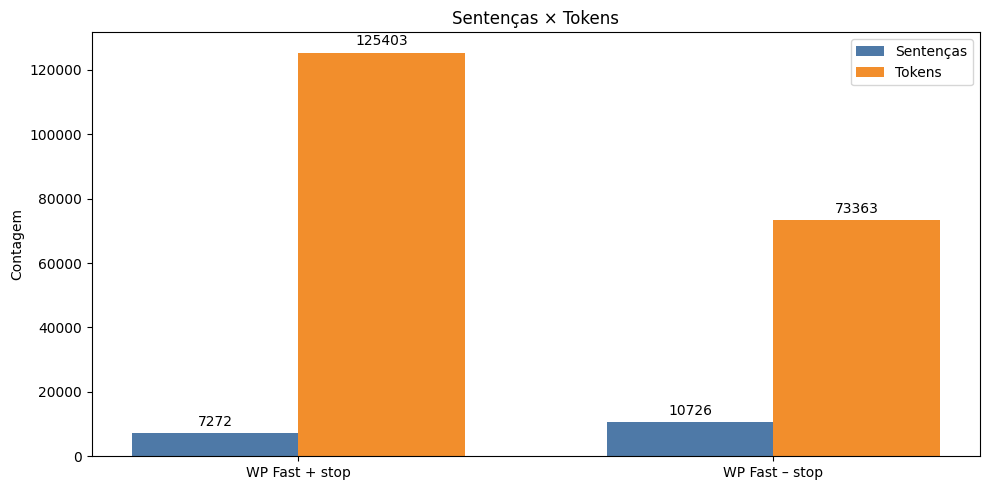


Gráfico Comparativo - Análise Gramatical:


<Figure size 1200x600 with 0 Axes>

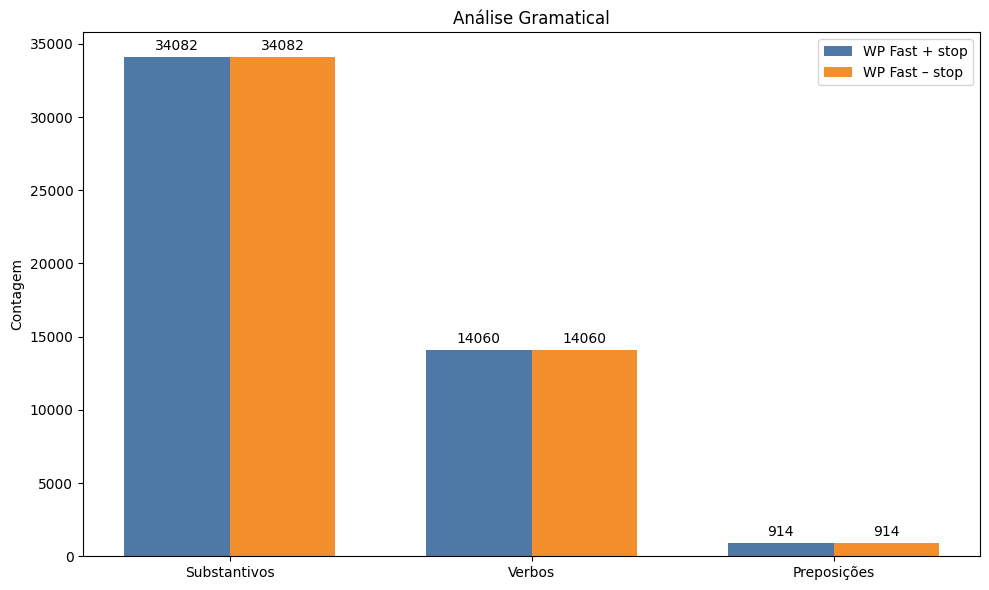

In [27]:
def plotar_grafico_sentencas_tokens(df):
    """
    Plota gráfico comparativo de sentenças e tokens
    """
    plt.figure(figsize=(12, 6))
    
    # Prepara dados
    conjuntos = df["Conjunto"].tolist()
    sentencas = df["Sentenças"].tolist()
    tokens = df["Tokens"].tolist()
    
    # Configura posições das barras
    x = np.arange(len(conjuntos))
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(10, 5))
    
    # Cria as barras
    rects1 = ax.bar(x - width/2, sentencas, width, label='Sentenças', color='#4e79a7')
    rects2 = ax.bar(x + width/2, tokens, width, label='Tokens', color='#f28e2c')
    
    # Configura o gráfico
    ax.set_title('Sentenças × Tokens')
    ax.set_ylabel('Contagem')
    ax.set_xticks(x)
    ax.set_xticklabels(conjuntos)
    ax.legend()
    
    # Adiciona rótulos com valores
    for rect in rects1:
        height = rect.get_height()
        ax.annotate(f'{height}',
                    xy=(rect.get_x() + rect.get_width()/2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')
    
    for rect in rects2:
        height = rect.get_height()
        ax.annotate(f'{height}',
                    xy=(rect.get_x() + rect.get_width()/2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

def plotar_grafico_gramatica(df):
    """
    Plota gráfico comparativo de substantivos, verbos e preposições
    """
    plt.figure(figsize=(12, 6))
    
    # Configura posições das barras
    categorias = ['Substantivos', 'Verbos', 'Preposições']
    conjuntos = df["Conjunto"].tolist()
    
    x = np.arange(len(categorias))
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Prepara dados
    valores_com_sw = [df.loc[0, 'Substantivos'], df.loc[0, 'Verbos'], df.loc[0, 'Preposições']]
    valores_sem_sw = [df.loc[1, 'Substantivos'], df.loc[1, 'Verbos'], df.loc[1, 'Preposições']]
    
    # Cria as barras
    rects1 = ax.bar(x - width/2, valores_com_sw, width, label=conjuntos[0], color='#4e79a7')
    rects2 = ax.bar(x + width/2, valores_sem_sw, width, label=conjuntos[1], color='#f28e2c')
    
    # Configura o gráfico
    ax.set_title('Análise Gramatical')
    ax.set_ylabel('Contagem')
    ax.set_xticks(x)
    ax.set_xticklabels(categorias)
    ax.legend()
    
    # Adiciona rótulos com valores
    for rect in rects1:
        height = rect.get_height()
        ax.annotate(f'{height}',
                    xy=(rect.get_x() + rect.get_width()/2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')
    
    for rect in rects2:
        height = rect.get_height()
        ax.annotate(f'{height}',
                    xy=(rect.get_x() + rect.get_width()/2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

linha = dados.loc[0]  # ou dados.iloc[0]

tabela_resumo = pd.DataFrame([{
    "Sentenças": linha["Sentenças"],
    "Média de sentenças": linha["Média de sentenças"],
    "Tokens": linha["Tokens"],
    "Média Tokens/Sent.": linha["Média Tokens/Sent."],
    "Substantivos": linha["Substantivos"],
    "Verbos": linha["Verbos"],
    "Preposições": linha["Preposições"]
}])
print("\nTabela (Com stopwords):")
display(tabela_resumo)

linha = dados.loc[1]
print("\n")
tabela_resumo = pd.DataFrame([{
    "Sentenças": linha["Sentenças"],
    "Média de sentenças": linha["Média de sentenças"],
    "Tokens": linha["Tokens"],
    "Média Tokens/Sent.": linha["Média Tokens/Sent."],
    "Substantivos": linha["Substantivos"],
    "Verbos": linha["Verbos"],
    "Preposições": linha["Preposições"]
}])
print("Tabela (Sem stopwords):")
display(tabela_resumo)


print("\n")

coluna_1 = pd.DataFrame(
    [item for item in dados["Top-10"][0].split(", ")],
    columns=["Top-10 (com stopwords)"],
    index=range(1, 11)
)

coluna_2 = pd.DataFrame(
    [item for item in dados["Top-10"][1].split(", ")],
    columns=["Top-10 (sem stopwords)"],
    index=range(1, 11)
)

# Junta lado a lado
df_top10_lado_a_lado = pd.concat([coluna_1, coluna_2], axis=1)
df_top10_lado_a_lado.index.name = "Posição"

# Exibe
display(df_top10_lado_a_lado)

coluna_1 = pd.DataFrame(
    [item for item in dados["Down-10"][0].split(", ")],
    columns=["Down-10 (com stopwords)"],
    index=range(1, 11)
)

coluna_2 = pd.DataFrame(
    [item for item in dados["Down-10"][1].split(", ")],
    columns=["Down-10 (sem stopwords)"],
    index=range(1, 11)
)

# Junta lado a lado
df_down10_lado_a_lado = pd.concat([coluna_1, coluna_2], axis=1)
df_down10_lado_a_lado.index.name = "Posição"
print("\n\n")
# Exibe
display(df_down10_lado_a_lado)

# Exibe gráficos
print("\nGráfico Comparativo - Sentenças × Tokens:")
plotar_grafico_sentencas_tokens(dados)

print("\nGráfico Comparativo - Análise Gramatical:")
plotar_grafico_gramatica(dados)

Extraindo: A Large Dataset of Spontaneous Speech with the Accent Spoken in São Paulo for Automatic Speech Recognition Evaluation
Extraindo: A Transformer-Based Tabular Approach to Detect Toxic Comments
Extraindo: An Ensemble of LLMs Finetuned with LoRA for NER in Portuguese Legal Documents
Extraindo: Aroeira: A Curated Corpus for the Portuguese Language with a Large Number of Tokens
Extraindo: Assessing European and Brazilian Portuguese LLMs for NER in Specialised Domains
Extraindo: Automatic Text Simplification for the Legal Domain in Brazilian Portuguese
Extraindo: Developing Resource-Efficient Clinical LLMs for Brazilian Portuguese
Extraindo: Diversity in Data for Speech Processing in Brazilian Portuguese
Extraindo: ERASMO: Leveraging Large Language Models for Enhanced Clustering Segmentation
Extraindo: Evaluating Large Language Models for Tax Law Reasoning
Extraindo: Evaluating Sentiment Quantification Methods in Brazilian Portuguese Corpora
Extraindo: Evaluating Short Text Stream 

,Dependência,Com Stopwords,Sem Stopwords,Diferença
0,case,22376,382,21994
1,punct,21192,21190,2
2,nmod,15916,15443,473
3,det,12666,329,12337
4,amod,8904,8289,615
5,obj,8082,7770,312
6,ROOT,7272,6784,488
7,obl,5609,4930,679
8,conj,5591,5355,236
9,nsubj,5367,4204,1163



Gráfico das Principais Dependências:


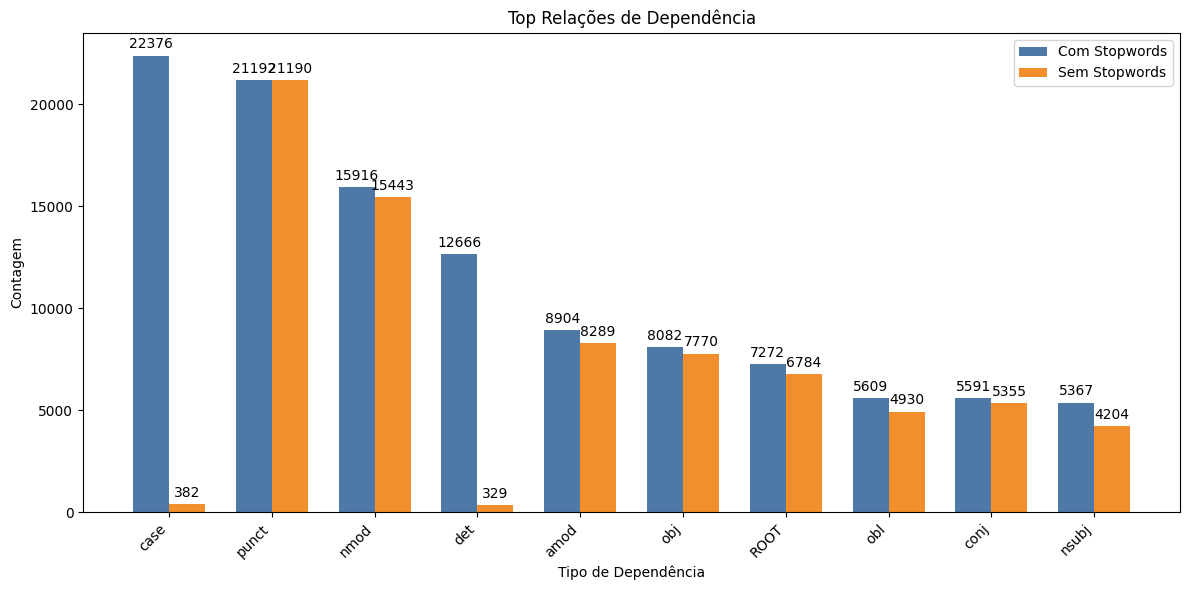

In [13]:
import matplotlib.pyplot as plt
def visualizar_grafico_dependencias(df_deps, top_n=10):
    """
    Gera um gráfico comparativo das dependências mais comuns
    """
    # Toma apenas as top_n dependências
    df_plot = df_deps.head(top_n).copy()
    
    # Configura posições das barras
    deps = df_plot["Dependência"].tolist()
    x = np.arange(len(deps))
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Cria as barras
    rects1 = ax.bar(x - width/2, df_plot["Com Stopwords"], width, label='Com Stopwords', color='#4e79a7')
    rects2 = ax.bar(x + width/2, df_plot["Sem Stopwords"], width, label='Sem Stopwords', color='#f28e2c')
    
    # Configura o gráfico
    ax.set_title('Top Relações de Dependência')
    ax.set_ylabel('Contagem')
    ax.set_xlabel('Tipo de Dependência')
    ax.set_xticks(x)
    ax.set_xticklabels(deps, rotation=45, ha='right')
    ax.legend()
    
    # Adiciona rótulos com valores
    for rect in rects1:
        height = rect.get_height()
        ax.annotate(f'{height}',
                    xy=(rect.get_x() + rect.get_width()/2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')
    
    for rect in rects2:
        height = rect.get_height()
        ax.annotate(f'{height}',
                    xy=(rect.get_x() + rect.get_width()/2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()


deps_com_sw = Counter()
deps_sem_sw = Counter()
for estrutura_artigo_corpus in corpus:
    print("Extraindo: " + estrutura_artigo_corpus["titulo"])
    texto = estrutura_artigo_corpus["artigo_completo_PT"]
    try:
        doc = nlp_pt(texto)
        
        # Extrai informações de dependência
        for token in doc:
            # Registra o tipo de dependência
            if not token.text.lower() in stopwords_pt:
                deps_sem_sw[token.dep_] += 1
            deps_com_sw[token.dep_] += 1
    except Exception as e:
        print(f"Erro ao processar bloco: {e}")
        
deps_combinadas = set(deps_com_sw.keys()) | set(deps_sem_sw.keys())
dados_comparacao = []

for dep in deps_combinadas:
    dados_comparacao.append({
        "Dependência": dep,
        "Com Stopwords": deps_com_sw.get(dep, 0),
        "Sem Stopwords": deps_sem_sw.get(dep, 0),
        "Diferença": deps_com_sw.get(dep, 0) - deps_sem_sw.get(dep, 0)
    })

# Ordena por contagem (com stopwords)
df_deps = pd.DataFrame(dados_comparacao).sort_values(
    by="Com Stopwords", ascending=False
).reset_index(drop=True)

print("\nTabela Comparativa de Dependências:")
display(df_deps.head(15))

# Visualiza gráfico de barras para as principais dependências
print("\nGráfico das Principais Dependências:")
visualizar_grafico_dependencias(df_deps)         

Carregando...

Lemas Mais Frequentes:


,Lema,Com Stopwords,Sem Stopwords,Diferença
0,de,9461,0,9461
1,o,7498,0,7498
2,e,3584,0,3584
3,de o,2970,0,2970
4,para,2494,0,2494
5,em,2488,0,2488
6,ser,2440,238,2202
7,um,2379,0,2379
8,em o,1580,0,1580
9,modelo,1546,1546,0



Distribuição por Classe Gramatical:


,Classe,POS,Ocorrências,Lemas Únicos,Ocorrências (sem SW),Lemas Únicos (sem SW),Proporção Únicas/Total
0,Substantivo,NOUN,34054,2972,32707,2936,0.087273
1,Preposição,ADP,22890,135,422,95,0.005898
2,Verbo,VERB,14060,1471,13258,1465,0.104623
3,Determinante,DET,12786,58,328,19,0.004536
4,Nome Próprio,PROPN,12434,3672,12194,3627,0.295319
5,Adjetivo,ADJ,10041,1400,9341,1386,0.139428
6,Numeral,NUM,6916,2030,6505,2011,0.293522
7,Advérbio,ADV,4088,316,1674,267,0.077299
8,Conjunção,CCONJ,4050,20,24,13,0.004938
9,SCONJ,SCONJ,2757,28,5,5,0.010156



Gráfico de Distribuição de Classes Gramaticais:


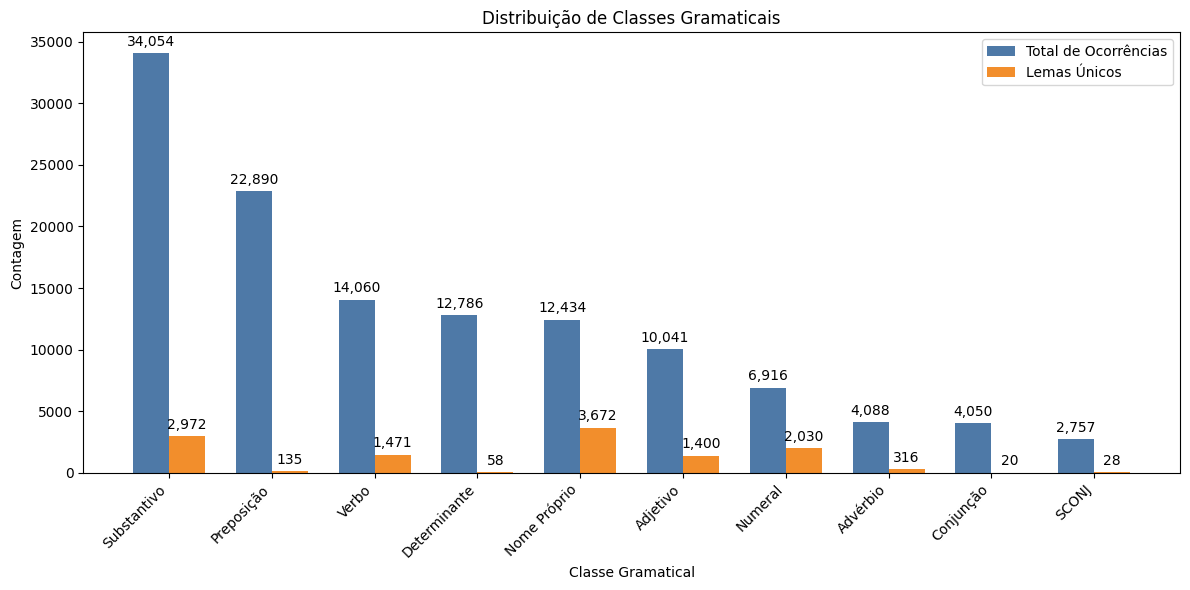


Gráfico de Diversidade Lexical:


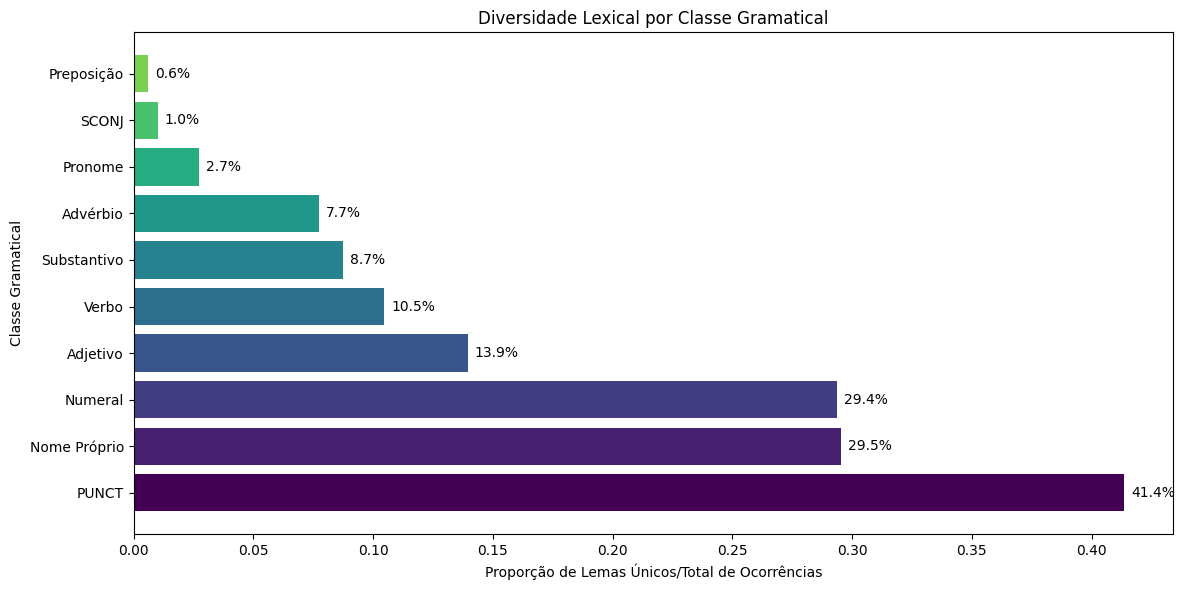


Nuvem de Palavras - Verbos:


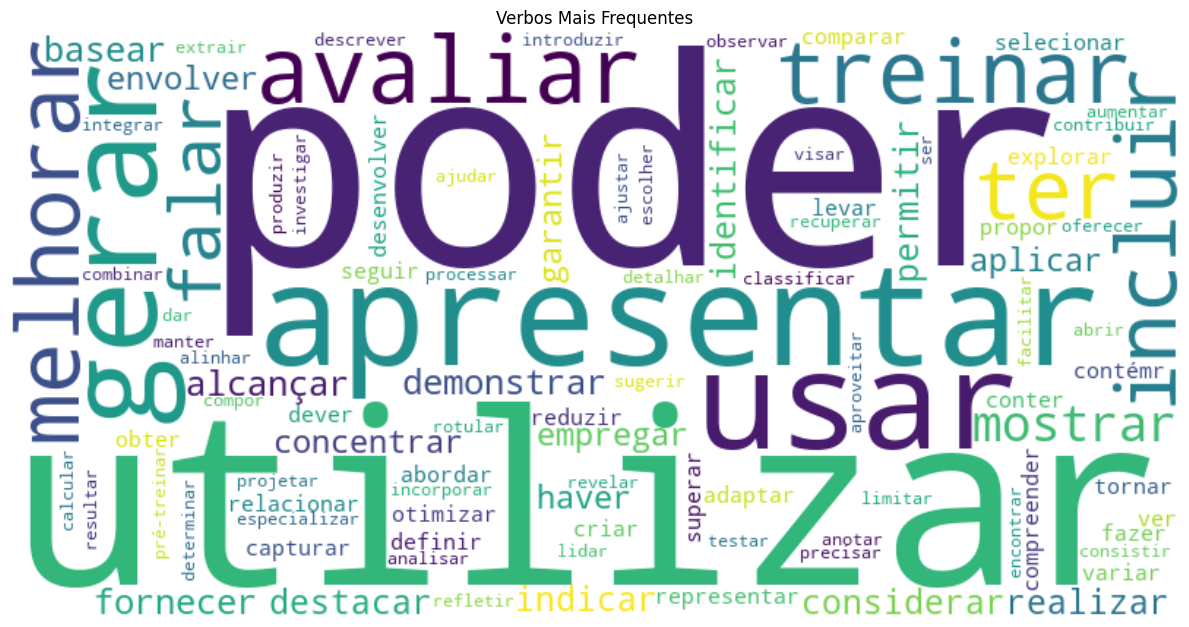


Nuvem de Palavras - Substantivos:


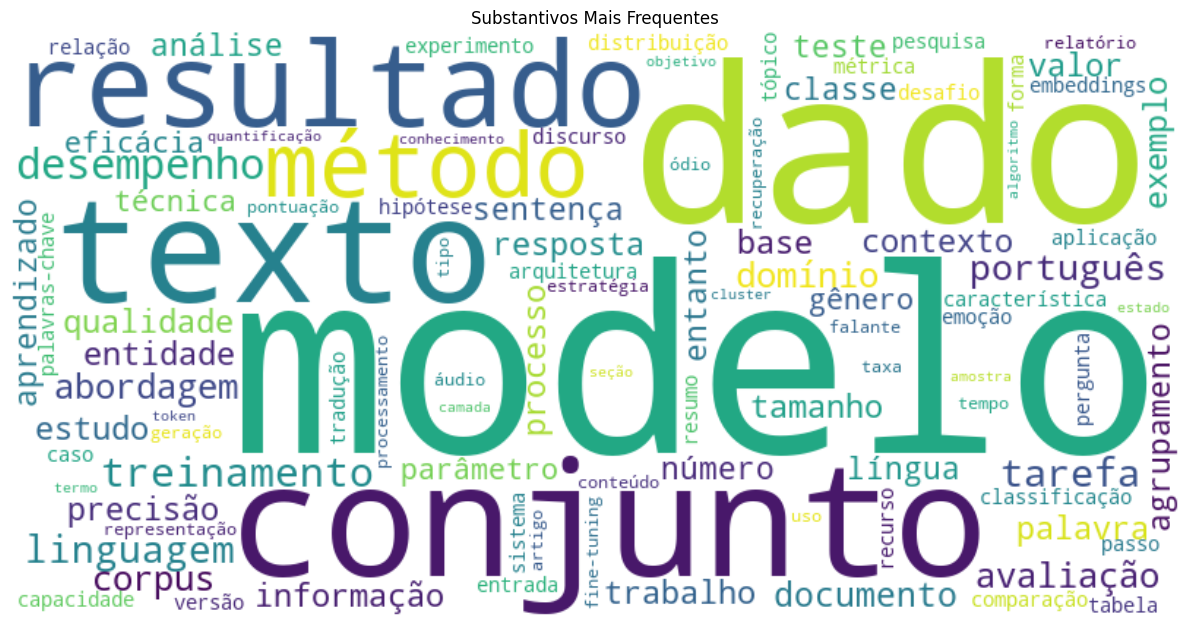

In [24]:
from collections import Counter, defaultdict
from wordcloud import WordCloud

def visualizar_distribuicao_pos(df_pos):
    """
    Gera um gráfico de barras para visualizar a distribuição das classes gramaticais
    """
    # Pega as 10 classes mais frequentes
    df_plot = df_pos.head(10).copy()
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Configuração de barras
    x = np.arange(len(df_plot))
    width = 0.35
    
    # Cria as barras para ocorrências totais e lemas únicos
    rects1 = ax.bar(x - width/2, df_plot["Ocorrências"], width, 
                   label='Total de Ocorrências', color='#4e79a7')
    rects2 = ax.bar(x + width/2, df_plot["Lemas Únicos"], width, 
                   label='Lemas Únicos', color='#f28e2c')
    
    # Configuração do gráfico
    ax.set_title('Distribuição de Classes Gramaticais')
    ax.set_ylabel('Contagem')
    ax.set_xlabel('Classe Gramatical')
    ax.set_xticks(x)
    ax.set_xticklabels(df_plot["Classe"], rotation=45, ha='right')
    ax.legend()
    
    # Adiciona rótulos
    for rect in rects1:
        height = rect.get_height()
        ax.annotate(f'{height:,}',
                    xy=(rect.get_x() + rect.get_width()/2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')
    
    for rect in rects2:
        height = rect.get_height()
        ax.annotate(f'{height:,}',
                    xy=(rect.get_x() + rect.get_width()/2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

# Estatística 2: Diversidade Lexical por Classe Gramatical
def visualizar_diversidade_lexical(df_pos):
    """
    Gera um gráfico que mostra a proporção entre lemas únicos e total de ocorrências
    por classe gramatical (índice de diversidade lexical)
    """
    # Filtra classes com pelo menos 100 ocorrências para relevância estatística
    df_plot = df_pos[df_pos["Ocorrências"] > 100].copy().sort_values(
        by="Proporção Únicas/Total", ascending=False
    ).head(10)
    
    # Prepara dados
    classes = df_plot["Classe"].tolist()
    proporcoes = df_plot["Proporção Únicas/Total"].tolist()
    
    # Cria o gráfico
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Barra horizontal para melhor visualização
    bars = ax.barh(classes, proporcoes, color=plt.cm.viridis(np.linspace(0, 0.8, len(classes))))
    
    # Configuração do gráfico
    ax.set_title('Diversidade Lexical por Classe Gramatical')
    ax.set_xlabel('Proporção de Lemas Únicos/Total de Ocorrências')
    ax.set_ylabel('Classe Gramatical')
    
    # Adiciona rótulos com percentual
    for i, bar in enumerate(bars):
        width = bar.get_width()
        ax.annotate(f'{width:.1%}',
                   xy=(width, bar.get_y() + bar.get_height()/2),
                   xytext=(5, 0),
                   textcoords="offset points",
                   ha='left', va='center')
    
    plt.tight_layout()
    plt.show()

# Função Extra: Nuvem de Palavras dos Lemas Mais Comuns por POS
def criar_nuvem_lemas(pos_data, pos_selecionado, titulo, top_n=100):
    """
    Cria uma nuvem de palavras com os lemas mais comuns para uma classe gramatical
    """
    from wordcloud import WordCloud
    
    # Verifica se temos dados para a classe selecionada
    if pos_selecionado not in pos_data:
        print(f"Classe gramatical '{pos_selecionado}' não encontrada nos dados.")
        return
    
    # Obtém os lemas mais comuns
    lemas = pos_data[pos_selecionado].most_common(top_n)
    
    # Cria o dicionário de frequências para a nuvem
    freq_dict = {lema: freq for lema, freq in lemas}
    
    # Gera a nuvem de palavras
    wordcloud = WordCloud(
        width=800, height=400,
        background_color='white',
        colormap='viridis',
        max_words=top_n,
        collocations=False
    ).generate_from_frequencies(freq_dict)
    
    # Exibe a nuvem
    plt.figure(figsize=(12, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(titulo)
    plt.tight_layout()
    plt.show()
# Contadores para armazenar resultados
lemas_com_sw = Counter()
lemas_sem_sw = Counter()
pos_com_sw = defaultdict(Counter)
pos_sem_sw = defaultdict(Counter)

print("Carregando...")
for estrutura_artigo_corpus in corpus:
    try:
        texto = estrutura_artigo_corpus["artigo_completo_PT"]
        doc = nlp_pt(texto)
        
        # Extrai lemas
        for token in doc:
            # Pula stopwords se necessário e tokens que não são palavras
            if token.is_punct or token.is_space:
                continue
            if not token.text.lower() in stopwords_pt:
                lemas_sem_sw[token.lemma_] += 1
                pos_sem_sw[token.pos_][token.lemma_] += 1
            
            # Registra o lema
            lemas_com_sw[token.lemma_] += 1
            
            # Registra o lema por classe gramatical
            pos_com_sw[token.pos_][token.lemma_] += 1
    except Exception as e:
        print(f"Erro ao processar bloco: {e}")

lemas_combinados = set(lemas_com_sw.keys()) | set(lemas_sem_sw.keys())
dados_lemas = []

for lema in lemas_combinados:
    dados_lemas.append({
        "Lema": lema,
        "Com Stopwords": lemas_com_sw.get(lema, 0),
        "Sem Stopwords": lemas_sem_sw.get(lema, 0),
        "Diferença": lemas_com_sw.get(lema, 0) - lemas_sem_sw.get(lema, 0)
    })

# Ordena por contagem (com stopwords)
df_lemas = pd.DataFrame(dados_lemas).sort_values(
    by="Com Stopwords", ascending=False
).reset_index(drop=True)

# Prepara dados para análise por classe gramatical
dados_pos = []

for pos in set(pos_com_sw.keys()) | set(pos_sem_sw.keys()):
    # Total de ocorrências por POS
    total_com_sw = sum(pos_com_sw[pos].values())
    total_sem_sw = sum(pos_sem_sw[pos].values())
    
    # Número único de lemas por POS
    unicos_com_sw = len(pos_com_sw[pos])
    unicos_sem_sw = len(pos_sem_sw[pos])
    
    # Mapeando códigos POS para nomes legíveis
    mapa_pos = {
        'NOUN': 'Substantivo', 'VERB': 'Verbo', 'ADJ': 'Adjetivo', 
        'ADV': 'Advérbio', 'ADP': 'Preposição', 'CCONJ': 'Conjunção',
        'DET': 'Determinante', 'PRON': 'Pronome', 'PROPN': 'Nome Próprio',
        'NUM': 'Numeral', 'AUX': 'Verbo Auxiliar', 'PART': 'Partícula'
    }
    
    pos_nome = mapa_pos.get(pos, pos)
    
    dados_pos.append({
        "Classe": pos_nome,
        "POS": pos,
        "Ocorrências": total_com_sw,
        "Lemas Únicos": unicos_com_sw,
        "Ocorrências (sem SW)": total_sem_sw,
        "Lemas Únicos (sem SW)": unicos_sem_sw,
        "Proporção Únicas/Total": unicos_com_sw / total_com_sw if total_com_sw else 0
    })

# Ordena por total de ocorrências
df_pos = pd.DataFrame(dados_pos).sort_values(
    by="Ocorrências", ascending=False
).reset_index(drop=True)

pos_data = pos_com_sw
if df_lemas is None:
    print("Não foi possível gerar análise de lematização.")
    sys.exit
    
# Exibe tabela dos lemas mais comuns
print("\nLemas Mais Frequentes:")
display(df_lemas.head(15))

# Exibe tabela de classes gramaticais
print("\nDistribuição por Classe Gramatical:")
display(df_pos)

# Visualiza distribuição de classes gramaticais
print("\nGráfico de Distribuição de Classes Gramaticais:")
visualizar_distribuicao_pos(df_pos)

# Visualiza diversidade lexical por classe
print("\nGráfico de Diversidade Lexical:")
visualizar_diversidade_lexical(df_pos)

print("\nNuvem de Palavras - Verbos:")
criar_nuvem_lemas(pos_data, 'VERB', 'Verbos Mais Frequentes')

print("\nNuvem de Palavras - Substantivos:")
criar_nuvem_lemas(pos_data, 'NOUN', 'Substantivos Mais Frequentes')